### 0. Check Pro

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

### 0.1. Pre

In [ ]:
!pip install trimesh

In [ ]:
!pip install pykan

In [ ]:
!pip install kan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 경로 설정
input_directory = '/content/drive/MyDrive/output_data_2'  # Colab 환경에 맞게 경로 수정
output_dirs = {
    'sdf': '/content/output_sdf',
    'sh': '/content/output_sh',
    'ellipsoid': '/content/output_ellipsoid',
    'superquadrics': '/content/output_superquadrics'
}

# 결과를 저장할 폴더 생성
for key, path in output_dirs.items():
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
!pip install rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 7.5 MB/s eta 0:00:00


### 0.2. Ellipsoid Fitting

In [ ]:
import os
import numpy as np
import trimesh
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
import concurrent.futures
import multiprocessing

# 1. Ellipsoid 피팅 함수 정의
def ellipsoid_model(params, x, y, z):
    a, b, c = params[0:3]
    cx, cy, cz = params[3:6]
    alpha, beta, gamma = params[6:9]
    R_mat = R.from_euler('xyz', [alpha, beta, gamma]).as_matrix()
    xyz = np.vstack((x - cx, y - cy, z - cz))
    rotated_xyz = R_mat @ xyz
    X, Y, Z = rotated_xyz
    return (X / a)**2 + (Y / b)**2 + (Z / c)**2 - 1

# Ellipsoid 피팅 함수 정의
def fit_ellipsoid(points):
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    a0, b0, c0 = np.std(x), np.std(y), np.std(z)
    cx0, cy0, cz0 = np.mean(x), np.mean(y), np.mean(z)
    angles0 = [0, 0, 0]
    initial_params = [a0, b0, c0, cx0, cy0, cz0] + angles0
    # 매개변수 경계 설정
    lower_bounds = [1e-3, 1e-3, 1e-3, -np.inf, -np.inf, -np.inf, -np.pi, -np.pi, -np.pi]
    upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.pi, np.pi, np.pi]
    result = least_squares(ellipsoid_model, initial_params, args=(x, y, z), bounds=(lower_bounds, upper_bounds))
    return result.x

# 파일 처리 함수 정의 (Ellipsoid만 변환)
def process_file(obj_file):
    try:
        # 각 출력 파일의 경로 설정
        ellipsoid_path = os.path.join(output_dirs['ellipsoid'], obj_file.replace('.obj', '_ellipsoid.npy'))


        file_path = os.path.join(input_directory, obj_file)
        mesh = trimesh.load(file_path)
        points = mesh.vertices

        # Ellipsoid 변환 및 저장
        ellipsoid_params = fit_ellipsoid(points)
        np.save(ellipsoid_path, ellipsoid_params)

    except Exception as e:
        print(f"Error processing {obj_file}: {e}")

if __name__ == "__main__":
    # 경로 설정
    input_directory = '/content/drive/MyDrive/output_data_2'  # Colab 환경에 맞게 수정하세요
    output_dirs = {
        'ellipsoid': '/content/drive/MyDrive/output_ellipsoid'
    }

    # 결과를 저장할 폴더 생성
    for key, path in output_dirs.items():
        if not os.path.exists(path):
            os.makedirs(path)

    # obj 파일 리스트 가져오기
    obj_files = [f for f in os.listdir(input_directory) if f.endswith('.obj')]

    # 병렬 처리 실행
    num_workers = multiprocessing.cpu_count()
    # Colab 환경에서는 ThreadPoolExecutor를 사용하는 것이 더 안정적일 수 있습니다.
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        list(tqdm(executor.map(process_file, obj_files), total=len(obj_files), desc="Processing .obj files"))


Processing .obj files: 100%|██████████| 1463/1463 [12:00<00:00,  2.03it/s]


In [14]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.7/703.7 kB 9.5 MB/s eta 0:00:00


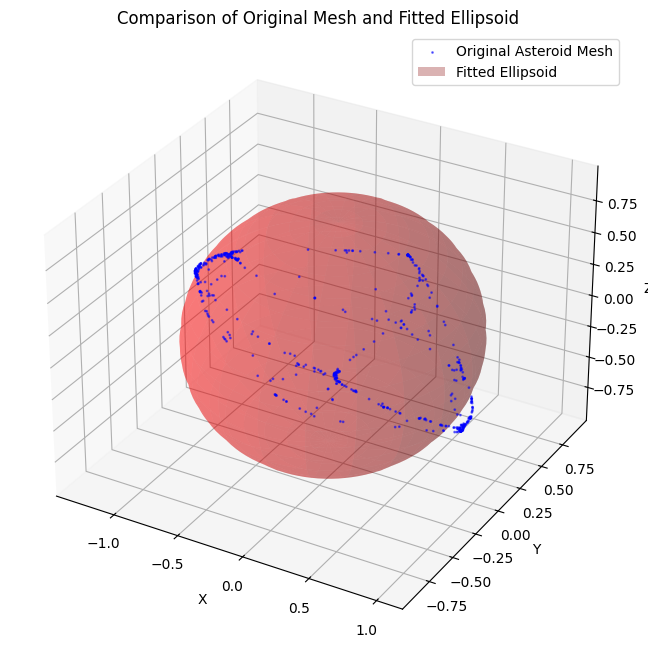

In [16]:
# 알고리즘을 이용한 3D Ellipsoid Fitting 및 Asteroid Mesh 비교
import os
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from math import sqrt

# 벡터의 투영 및 반사 길이 계산 함수
def proj_length(v, v_on):
    on_norm = np.linalg.norm(v_on)
    v_len = np.linalg.norm(v)

    projection_len = 0
    rejection_len = 0
    if on_norm > 0.01:
        projection_len = np.dot(v, v_on) / on_norm

        if v_len > abs(projection_len):
            rejection_len = sqrt(v_len ** 2 - projection_len ** 2)

    return projection_len, rejection_len

# 주축을 찾고 타원체의 초점을 계산하는 함수
def find_foci(arr_pts):
    _pts_search_animations = []

    # 점들을 셔플하여 주축 탐색
    pts = np.copy(arr_pts)
    np.random.shuffle(pts)

    pts_len = len(pts)
    pt_average = np.sum(pts, axis=0) / pts_len

    vec_major = pt_average * 0
    minor_max, major_max = 0, 0

    # 주축 탐색 반복
    for pt_cur in pts:
        vec_cur = pt_cur - pt_average
        proj_len, rej_len = proj_length(vec_cur, vec_major)

        if proj_len < 0:
            vec_cur = -vec_cur
        vec_major += (vec_cur - vec_major) / pts_len

        major_max = max(major_max, abs(proj_len))
        minor_max = max(minor_max, rej_len)
        _pts_search_animations.append([pt_cur, np.copy(vec_major)])

    # 구 형태일 경우 주축과 부축의 길이가 거의 동일
    if major_max < minor_max:
        major_max, minor_max = minor_max, major_max

    vec_major_unit = vec_major / np.linalg.norm(vec_major)
    vec_foci = vec_major_unit * sqrt(major_max ** 2 - minor_max ** 2)

    foci_1 = pt_average + vec_foci
    foci_2 = pt_average - vec_foci

    return foci_1, foci_2, _pts_search_animations

# 타원체를 찾는 함수
# 평균 거리를 사용하여 타원체 반경을 더 정확히 계산
def find_ellipsoid(arr_pts):
    foci_1, foci_2, _pts_search_animations = find_foci(arr_pts)

    # 평균 거리 계산을 통해 장축 반경을 구합니다
    distances = [np.linalg.norm(pt - foci_1) + np.linalg.norm(pt - foci_2) for pt in arr_pts]
    string_pro_calc = np.mean(distances)  # 평균 거리 사용

    return foci_1, foci_2, string_pro_calc, _pts_search_animations

# 파일 처리 및 시각화 함수 정의
def process_and_visualize(obj_file):
    file_path = os.path.join(input_directory, obj_file)
    mesh = trimesh.load(file_path)
    points = mesh.vertices

    # Ellipsoid 찾기
    foci_1, foci_2, stg, pts_animations = find_ellipsoid(points)

    # 시각화
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 원래 소행성 메쉬 시각화
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.5, s=1, label='Original Asteroid Mesh', color='b')

    # Ellipsoid 시각화
    vec_foci = foci_2 - foci_1
    vec_foci_len = np.linalg.norm(vec_foci)

    a = stg / 2  # 장축 반경
    b = np.sqrt(stg ** 2 - vec_foci_len ** 2) / 2  # 단축 반경

    # 타원체 회전을 위한 변환 행렬 생성
    transform_mtr = mtr_rotation_from_x(vec_foci)

    # 타원체 전체 표면 그리기
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = a * np.outer(np.cos(u), np.sin(v))
    y = b * np.outer(np.sin(u), np.sin(v))
    z = b * np.outer(np.ones_like(u), np.cos(v))

    ellipsoid_points = np.vstack((x.ravel(), y.ravel(), z.ravel()))
    ellipsoid_points = np.dot(transform_mtr, ellipsoid_points)
    x_rot = ellipsoid_points[0, :] + (foci_1[0] + foci_2[0]) / 2
    y_rot = ellipsoid_points[1, :] + (foci_1[1] + foci_2[1]) / 2
    z_rot = ellipsoid_points[2, :] + (foci_1[2] + foci_2[2]) / 2
    ax.plot_surface(x_rot.reshape(x.shape), y_rot.reshape(y.shape), z_rot.reshape(z.shape), color='r', alpha=0.3, rstride=5, cstride=5, label='Fitted Ellipsoid')

    # 축 설정 및 시각화
    ax.set_title("Comparison of Original Mesh and Fitted Ellipsoid")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()

# 벡터 회전 행렬 계산
def mtr_rotation_from_x(vec_to):
    un_z = np.array([0, 0, 1])

    mtr_ex = vec_to / np.linalg.norm(vec_to)
    mtr_y = np.cross(un_z, vec_to)
    mtr_ey = mtr_y / np.linalg.norm(mtr_y)
    mtr_z = np.cross(mtr_ex, mtr_ey)
    mtr_ez = mtr_z / np.linalg.norm(mtr_z)

    transform_mtr = np.array([mtr_ex, mtr_ey, mtr_ez])
    return transform_mtr.T

if __name__ == "__main__":
    # 경로 설정
    input_directory = '/content/drive/MyDrive/output_data_2'  # Colab 환경에 맞게 수정하세요

    # 첫 번째 파일을 피팅하고 파라미터 출력 및 시각화
    obj_files = [f for f in os.listdir(input_directory) if f.endswith('.obj')]
    if obj_files:
        obj_file = obj_files[1]
        process_and_visualize(obj_file)

In [2]:
import os
import numpy as np
import csv

# 경로 설정
input_directory = '/content/drive/MyDrive/output_ellipsoid'  # Colab 환경에 맞게 수정하세요
output_csv_path = '/content/drive/MyDrive/output_ellipsoid.csv'  # CSV 파일 저장 경로

# obj 파일 리스트 가져오기
npy_files = [f for f in os.listdir(input_directory) if f.endswith('.npy')]

# CSV 파일 생성 및 헤더 작성
with open(output_csv_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # 헤더 작성
    csv_writer.writerow(['file_name', 'a', 'b', 'c', 'cx', 'cy', 'cz', 'alpha', 'beta', 'gamma'])

    # 각 npy 파일 처리
    for npy_file in npy_files:
        # npy 파일 경로
        file_path = os.path.join(input_directory, npy_file)

        # npy 파일 로드
        ellipsoid_params = np.load(file_path)

        # 파일 이름에서 확장자 제거 (예: 'Ceres_shape_ellipsoid.npy' -> 'Ceres_shape_ellipsoid')
        file_name = os.path.splitext(npy_file)[0]

        # CSV에 결과 저장 (파일 이름과 피팅된 9개의 매개변수)
        csv_writer.writerow([file_name] + ellipsoid_params.tolist())

print(f"CSV 파일이 '{output_csv_path}'에 성공적으로 생성되었습니다.")


CSV 파일이 '/content/drive/MyDrive/output_ellipsoid.csv'에 성공적으로 생성되었습니다.


In [3]:
from google.colab import files

# 다운로드할 파일 경로 설정
file_path = '/content/drive/MyDrive/output_ellipsoid.csv'

# 파일 다운로드
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 0.6. DAMIT LC Crawling


In [ ]:
import requests
from bs4 import BeautifulSoup
import os

# DAMIT 데이터베이스에서 소행성의 lc.txt 파일을 다운로드하는 크롤러

# 저장할 디렉토리 (D: 외장 SSD)
output_dir = "D:/DAMIT_dataset"
os.makedirs(output_dir, exist_ok=True)
input_training_domain_dir = os.path.join(output_dir, "input_training_domain")  # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 input training domain

# 하위 디렉토리 생성
os.makedirs(input_training_domain_dir, exist_ok=True)  # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 input training domain

# 첫 번째 페이지 URL
first_page_url = "https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc"

# 모든 페이지를 순회
page_number = 1
while True:
    if page_number == 1:
        url = first_page_url
    else:
        url = f"https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:{page_number}"

    print(f"Requesting URL: {url}")  # 요청 URL 출력
    response = requests.get(url)

    # 요청 상태 확인
    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}. Status code: {response.status_code}")
        break

    soup = BeautifulSoup(response.text, "html.parser")
    print("Page retrieved successfully!")  # 페이지 성공적으로 가져옴

    # 소행성 이름과 모델 링크 저장
    asteroid_rows = soup.find_all('tr', class_='damit-asteroid-row')

    if not asteroid_rows:
        print(f"No more asteroid rows found on page {page_number}. Ending crawl.")
        break

    for asteroid_row in asteroid_rows:
        # 소행성 이름 가져오기
        asteroid_name = asteroid_row.find('th').get_text(strip=True)  # <th>에서 이름 가져오기
        print(f"Found asteroid: {asteroid_name}")  # 페이지에서 찾은 소행성 이름 출력

        # 방금 찾은 소행성에 딸려있는 모델 개수 셀거임.
        model_row_count = 0
        current_row = asteroid_row

        while True:
            # 다음 행으로 넘어가기
            next_row = current_row.find_next_sibling('tr')

            # 모델 행 찾기
            if next_row and 'damit-model-row' in next_row.get('class', []):  # 모델이 있는 행인 경우
                model_row_count += 1  # 하나의 소행성에 대해 몇 개의 모델이 있는지 셈.
                current_row = next_row
            else:  # 새로운 소행성이 있는 행인 경우
                break

        # 특이해가 존재하는 경우 (모델이 1개인 경우)
        if model_row_count == 1:
            print(f"Unique model found for asteroid: {asteroid_name}")  # 특이해가 존재하는 소행성을 찾았다고 출력

            # lc.txt 링크 찾기: 첫 번째 <td>의 두 번째 <a> 태그에 들어있음.
            lc_links = asteroid_row.find_all('td')[0].find_all('a')  # 첫 번째 <td>의 모든 <a> 태그
            if len(lc_links) > 1:
                lc_url = lc_links[1]['href']  # 두 번째 <a> 태그의 href: 여기에 lc.txt 나오는 링크 있음.
                if not lc_url.startswith('http'):
                    lc_url = "https://astro.troja.mff.cuni.cz" + lc_url  # 링크가 상대경로로 주어지므로, base url과 결합해야 온전한 주소.

                print(f"Downloading lc.txt from: {lc_url}")
                lc_response = requests.get(lc_url)
                lc_filename = os.path.join(input_training_domain_dir, f"{asteroid_name}_lc.txt")  # 첨에 만든 input 데이터 폴더에 저장합니다
                with open(lc_filename, 'w') as f:
                    f.write(lc_response.text)
                print(f"Saved: {lc_filename}")
            else:
                print("lc.txt link not found!")

    page_number += 1

print("모든 페이지에서 파일 다운로드 완료!")  # 모든 페이지 크롤링 완료하면 끝


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Found asteroid: (14667) 1999 CS19
Found asteroid: (14669) Beletic
Found asteroid: (14681) Estellechurch
Found asteroid: (14686)
Unique model found for asteroid: (14686)
Saved: D:/DAMIT_dataset/input_training_domain/(14686)_lc.txt
Found asteroid: (14691) 2000 AK119
Found asteroid: (14717)
Unique model found for asteroid: (14717)
Saved: D:/DAMIT_dataset/input_training_domain/(14717)_lc.txt
Found asteroid: (14728) Schuchardt
Unique model found for asteroid: (14728) Schuchardt
Saved: D:/DAMIT_dataset/input_training_domain/(14728) Schuchardt_lc.txt
Found asteroid: (14729)
Found asteroid: (14730)
Found asteroid: (14736)
Unique model found for asteroid: (14736)
Saved: D:/DAMIT_dataset/input_training_domain/(14736)_lc.txt
Found asteroid: (14739) Edgarchavez
Requesting URL: https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:280
Page retrieved successfully!
Found asteroid: (14759)
Unique model found for aste

ConnectTimeout: HTTPSConnectionPool(host='astro.troja.mff.cuni.cz', port=443): Max retries exceeded with url: /projects/damit/light_curves/exportAllForAsteroid/6431/plaintext (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7d84d93e2800>, 'Connection to astro.troja.mff.cuni.cz timed out. (connect timeout=None)'))

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

# DAMIT 데이터베이스에서 소행성의 lc.txt 파일을 다운로드하는 크롤러

# 저장할 디렉토리 (D: 외장 SSD)
output_dir = "D:/DAMIT_dataset"
os.makedirs(output_dir, exist_ok=True)
input_training_domain_dir = os.path.join(output_dir, "input_training_domain")  # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 input training domain

# 하위 디렉토리 생성
os.makedirs(input_training_domain_dir, exist_ok=True)  # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 input training domain

# 첫 번째 페이지 URL
first_page_url = "https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc"

# 모든 페이지를 순회
page_number = 1
start_found = False
while True:
    if page_number == 1:
        url = first_page_url
    else:
        url = f"https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:{page_number}"

    print(f"Requesting URL: {url}")  # 요청 URL 출력
    response = requests.get(url)

    # 요청 상태 확인
    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}. Status code: {response.status_code}")
        break

    soup = BeautifulSoup(response.text, "html.parser")
    print("Page retrieved successfully!")  # 페이지 성공적으로 가져옴

    # 소행성 이름과 모델 링크 저장
    asteroid_rows = soup.find_all('tr', class_='damit-asteroid-row')

    if not asteroid_rows:
        print(f"No more asteroid rows found on page {page_number}. Ending crawl.")
        break

    for asteroid_row in asteroid_rows:
        # 소행성 이름 가져오기
        asteroid_name = asteroid_row.find('th').get_text(strip=True)  # <th>에서 이름 가져오기

        # 시작 지점 찾기: (28709) 2000 GY96
        if not start_found:
            if asteroid_name == "(28709) 2000 GY96":
                start_found = True
            else:
                continue

        print(f"Found asteroid: {asteroid_name}")  # 페이지에서 찾은 소행성 이름 출력

        # 방금 찾은 소행성에 딸려있는 모델 개수 셀거임.
        model_row_count = 0
        current_row = asteroid_row

        while True:
            # 다음 행으로 넘어가기
            next_row = current_row.find_next_sibling('tr')

            # 모델 행 찾기
            if next_row and 'damit-model-row' in next_row.get('class', []):  # 모델이 있는 행인 경우
                model_row_count += 1  # 하나의 소행성에 대해 몇 개의 모델이 있는지 셈.
                current_row = next_row
            else:  # 새로운 소행성이 있는 행인 경우
                break

        # 특이해가 존재하는 경우 (모델이 1개인 경우)
        if model_row_count == 1:
            print(f"Unique model found for asteroid: {asteroid_name}")  # 특이해가 존재하는 소행성을 찾았다고 출력

            # lc.txt 링크 찾기: 첫 번째 <td>의 두 번째 <a> 태그에 들어있음.
            lc_links = asteroid_row.find_all('td')[0].find_all('a')  # 첫 번째 <td>의 모든 <a> 태그
            if len(lc_links) > 1:
                lc_url = lc_links[1]['href']  # 두 번째 <a> 태그의 href: 여기에 lc.txt 나오는 링크 있음.
                if not lc_url.startswith('http'):
                    lc_url = "https://astro.troja.mff.cuni.cz" + lc_url  # 링크가 상대경로로 주어지므로, base url과 결합해야 온전한 주소.

                lc_filename = os.path.join(input_training_domain_dir, f"{asteroid_name}_lc.txt")  # 첨에 만든 input 데이터 폴더에 저장합니다
                # 이미 파일이 존재하는 경우 스킵
                if os.path.exists(lc_filename):
                    print(f"File {lc_filename} already exists. Skipping download.")
                    continue

                print(f"Downloading lc.txt from: {lc_url}")
                lc_response = requests.get(lc_url)
                with open(lc_filename, 'w') as f:
                    f.write(lc_response.text)
                print(f"Saved: {lc_filename}")
            else:
                print("lc.txt link not found!")

    page_number += 1

print("모든 페이지에서 파일 다운로드 완료!")  # 모든 페이지 크롤링 완료하면 끝


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Found asteroid: (41344)
Found asteroid: (41345)
Unique model found for asteroid: (41345)
Saved: D:/DAMIT_dataset/input_training_domain/(41345)_lc.txt
Requesting URL: https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:475
Page retrieved successfully!
Found asteroid: (41347)
Unique model found for asteroid: (41347)
Saved: D:/DAMIT_dataset/input_training_domain/(41347)_lc.txt
Found asteroid: (41349) 2000 AA24
Unique model found for asteroid: (41349) 2000 AA24
Saved: D:/DAMIT_dataset/input_training_domain/(41349) 2000 AA24_lc.txt
Found asteroid: (41356)
Found asteroid: (41358) 2000 AJ54
Unique model found for asteroid: (41358) 2000 AJ54
Saved: D:/DAMIT_dataset/input_training_domain/(41358) 2000 AJ54_lc.txt
Found asteroid: (41362)
Found asteroid: (41367)
Unique model found for asteroid: (41367)
Saved: D:/DAMIT_dataset/input_training_domain/(41367)_lc.txt
Found asteroid: (41369)
Found asteroid: (41382)
F

KeyboardInterrupt: 

### 0.7. DAMIT Shape Crawling

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

#DAMIT database의 소행성 목록 페이지 html 형식이 table이래요. 말그대로 표를 나타내는 html 형식이라는데, 그 안에서 각 행은 <tr>로 표시되고, 각 행의 헤더는 <th>로, 각 행의 cell(열)은 <td>로 표시된대요
#그리고 html 파일에서 어떤 ... 링크를 지정할 때는 <a href="링크 url"> 이런 식으로 쓴다고 합니다.

# 저장할 디렉토리 (D: 외장 SSD)
output_dir = "D:/DAMIT_dataset"
os.makedirs(output_dir, exist_ok=True)
input_training_domain_dir = os.path.join(output_dir, "input_training_domain") # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 input training domain
output_data_1_dir = os.path.join(output_dir, "output_data_1") # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 output data - shape.txt 파일 받음
output_data_2_dir = os.path.join(output_dir, "output_data_2") # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 output data - shape.obj 파일 받음

# 하위 디렉토리 생성
os.makedirs(input_training_domain_dir, exist_ok=True) # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 input training domain
os.makedirs(output_data_1_dir, exist_ok=True) # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 output data - shape.txt 파일 받음
os.makedirs(output_data_2_dir, exist_ok=True) # 외장 SSD의 DAMIT_dataset 폴더의 하위 폴더 output data - shape.obj 파일 받음

# 테스트할 페이지 수 (1~2)
# DAMIT 데이터베이스 들어가보면, 소행성이 목록화되어있고 각각의 모델이 그 아래 행에 정리되어 있음. 그렇게 된 페이지가 총 717페이지인데, 여기서는 테스트용으로 2페이지까지만 하는거.
# 여기에 입력하는 페이지수까지 크롤링(?)함
test_pages = 2

# 첫 번째 페이지 URL
# DAMIT database 첫번째 페이지는 아래와 같은 링크 주소인데, 2페이지부터는 이 뒤에 /page:(페이지번호)가 붙는 반면 첫페이지엔 안 붙음. 그래서 첫번째만 따로 해줌.
first_page_url = "https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc"

# 모든 페이지를 순회
for page_number in range(1, test_pages + 1):
    if page_number == 1:
        url = first_page_url
    else:
        url = f"https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:{page_number}"

    print(f"Requesting URL: {url}")  # 요청 URL 출력
    response = requests.get(url)

    # 요청 상태 확인
    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}. Status code: {response.status_code}")
        continue

    soup = BeautifulSoup(response.text, "html.parser")
    print("Page retrieved successfully!")  # 페이지 성공적으로 가져옴

    # 소행성 이름과 모델 링크 저장
    asteroid_rows = soup.find_all('tr', class_='damit-asteroid-row')

    for asteroid_row in asteroid_rows:
        # 소행성 이름 가져오기
        asteroid_name = asteroid_row.find('th').get_text(strip=True)  # <th>에서 이름 가져오기. asteroid_row 행의 헤더에 그 소행성의 이름이 있음. 파일 저장할 때 그 이름을 쓸거라 여기서 확인함.
        print(f"Found asteroid: {asteroid_name}")  # 페이지에서 찾은 소행성 이름 출력

        # 방금 찾은 소행성에 딸려있는 모델 개수 셀거임.
        model_row_count = 0
        current_row = asteroid_row

        while True:
            # 다음 행으로 넘어가기
            next_row = current_row.find_next_sibling('tr')

            # 모델 행 찾기
            if next_row and 'damit-model-row' in next_row.get('class', []): #모델이 있는 행인 경우
                model_row_count += 1 #하나의 소행성에 대해 몇개의 모델이 있는지 셈.
                current_row = next_row
            else: #새로운 소행성이 있는 행인 경우
                break

        # 특이해가 존재하는 경우 (모델이 1개인 경우)
        if model_row_count == 1:
            print(f"Unique model found for asteroid: {asteroid_name}") #특이해가 존재하는 소행성을 찾았다고 출력

            # lc.txt 링크 찾기: 첫 번째 <td>의 두 번째 <a> 태그에 들어있음.
            lc_links = asteroid_row.find_all('td')[0].find_all('a')  # 첫 번째 <td>의 모든 <a> 태그
            if len(lc_links) > 1:
                lc_url = lc_links[1]['href']  # 두 번째 <a> 태그의 href: 여기에 lc.txt 나오는 링크 있음.
                if not lc_url.startswith('http'):
                    lc_url = "https://astro.troja.mff.cuni.cz" + lc_url #링크가 상대경로로 주어지므로, base url과 결합해야 온전한 주소.

                print(f"Downloading lc.txt from: {lc_url}")
                lc_response = requests.get(lc_url)
                lc_filename = os.path.join(input_training_domain_dir, f"{asteroid_name}_lc.txt") # 첨에 만든 input 데이터 폴더에 저장합니다
                with open(lc_filename, 'w') as f:
                    f.write(lc_response.text)
                print(f"Saved: {lc_filename}")
            else:
                print("lc.txt link not found!")

            # shape.txt 및 shape.obj 링크 찾기: 얘네는 model row의 5번째 td에 있음.
            shape_link = current_row.find_all('td')[4].find('a', href=lambda href: href and "shape.txt" in href) #5번째 td에 있는 a 태그 중에, href에 shape.txt가 포함된 것
            obj_link = current_row.find_all('td')[4].find('a', href=lambda href: href and "shape.obj" in href) #5번째 td에 있는 a 태그 중에, href에 shape.obj가 포함된 것

            # shape.txt 다운로드
            if shape_link:
                shape_url = shape_link['href']
                if not shape_url.startswith('http'):
                    shape_url = "https://astro.troja.mff.cuni.cz" + shape_url

                print(f"Downloading shape.txt from: {shape_url}")
                shape_response = requests.get(shape_url)
                shape_filename = os.path.join(output_data_1_dir, f"{asteroid_name}_shape.txt") # 첨에 만든 output1 데이터 폴더에 저장합니다
                with open(shape_filename, 'w') as f:
                    f.write(shape_response.text)
                print(f"Saved: {shape_filename}")
            else:
                print("shape.txt link not found!")

            # shape.obj 다운로드
            if obj_link:
                obj_url = obj_link['href']
                if not obj_url.startswith('http'):
                    obj_url = "https://astro.troja.mff.cuni.cz" + obj_url

                print(f"Downloading shape.obj from: {obj_url}")
                obj_response = requests.get(obj_url)
                obj_filename = os.path.join(output_data_2_dir, f"{asteroid_name}_shape.obj") # 첨에 만든 output2 데이터 폴더에 저장합니다
                with open(obj_filename, 'w') as f:
                    f.write(obj_response.text)
                print(f"Saved: {obj_filename}")
            else:
                print("shape.obj link not found!")

print("모든 페이지에서 파일 다운로드 완료!") # 모든 페이지 크롤링(?) 완료하면 끄읕

### 0.8. DAMIT KAN Input Crawling
$\lambda, \beta, P$

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import csv

# DAMIT 데이터베이스 저장할 디렉토리 (D: 외장 SSD)
output_dir = "D:/DAMIT_dataset"
os.makedirs(output_dir, exist_ok=True)

# CSV 파일 생성
csv_filename = os.path.join(output_dir, "asteroid.csv")
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # 헤더 작성
    writer.writerow(["asteroid", "lambda", "beta", "P"])

# 테스트할 페이지 수 (1~2)
test_pages = 717

# 첫 번째 페이지 URL
first_page_url = "https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc"

# 모든 페이지를 순회
for page_number in range(1, test_pages + 1):
    if page_number == 1:
        url = first_page_url
    else:
        url = f"https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:{page_number}"

    print(f"Requesting URL: {url}")  # 요청 URL 출력
    response = requests.get(url)

    # 요청 상태 확인
    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}. Status code: {response.status_code}")
        continue

    soup = BeautifulSoup(response.text, "html.parser")
    print("Page retrieved successfully!")  # 페이지 성공적으로 가져옴

    # 소행성 이름과 모델 링크 저장
    asteroid_rows = soup.find_all('tr', class_='damit-asteroid-row')

    for asteroid_row in asteroid_rows:
        # 소행성 이름 가져오기
        asteroid_name = asteroid_row.find('th').get_text(strip=True)
        print(f"Found asteroid: {asteroid_name}")

        # 모델 행 탐색
        model_row_count = 0
        current_row = asteroid_row

        while True:
            # 다음 행으로 넘어가기
            next_row = current_row.find_next_sibling('tr')

            # 모델 행인지 확인
            if next_row and 'damit-model-row' in next_row.get('class', []):
                model_row_count += 1
                current_row = next_row
            else:
                break

        # 특이해가 존재하는 경우 (모델이 1개인 경우)
        if model_row_count == 1:
            print(f"Unique model found for asteroid: {asteroid_name}")

            # lambda, beta, P 값을 추출
            lambda_value = current_row.find_all('td')[1].find('span').get_text(strip=True)
            beta_value = current_row.find_all('td')[2].find('span').get_text(strip=True)
            P_value = current_row.find_all('td')[3].find('span').get_text(strip=True)

            # CSV 파일에 기록
            with open(csv_filename, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([asteroid_name, lambda_value, beta_value, P_value])
            print(f"Saved data for {asteroid_name} in CSV")

print("CSV 파일 작성 완료")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Unique model found for asteroid: (64147)
Saved data for (64147) in CSV
Found asteroid: (64166)
Unique model found for asteroid: (64166)
Saved data for (64166) in CSV
Found asteroid: (64187)
Unique model found for asteroid: (64187)
Saved data for (64187) in CSV
Requesting URL: https://astro.troja.mff.cuni.cz/projects/damit/asteroids/browse/sort:Asteroid.number/direction:asc/page:577
Page retrieved successfully!
Found asteroid: (64192)
Found asteroid: (64238)
Found asteroid: (64292) 2001 UF13
Found asteroid: (64302)
Unique model found for asteroid: (64302)
Saved data for (64302) in CSV
Found asteroid: (64354)
Unique model found for asteroid: (64354)
Saved data for (64354) in CSV
Found asteroid: (64361)
Unique model found for asteroid: (64361)
Saved data for (64361) in CSV
Found asteroid: (64385)
Unique model found for asteroid: (64385)
Saved data for (64385) in CSV
Found asteroid: (64480) 2001 VG45
Found asteroid: (64506) 2001 VJ76
Found asteroid: (645